Football (or soccer to my American readers) is full of clichés: "It's a game of two halves", "taking it one game at a time" and "Liverpool have failed to win the Premier League". You're less likely to hear "Treating the number of goals scored by each team as independent Poisson processes, statistical modelling suggests that the home team have a 60% chance of winning today"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam
from IPython.core.pylabtools import figsize
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Dataset and motivation slide

We'll import all match results from the recently concluded Premier League (2016/17) season. The model is founded on the number of goals scored/conceded by each team. Teams that have been higher scorers in the past have a greater likelihood of scoring goals in the future.

In [2]:
!wget http://www.football-data.co.uk/mmz4281/1617/E0.csv

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/chuanjie/.wget-hsts'. HSTS will be disabled.
--2019-06-04 16:13:31--  http://www.football-data.co.uk/mmz4281/1617/E0.csv
Resolving www.football-data.co.uk (www.football-data.co.uk)... 217.160.0.246
Connecting to www.football-data.co.uk (www.football-data.co.uk)|217.160.0.246|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99990 (98K) [text/csv]
Saving to: ‘E0.csv.2’

E0.csv.2            100%[===================>]  97.65K   206KB/s    in 0.5s    

2019-06-04 16:13:32 (206 KB/s) - ‘E0.csv.2’ saved [99990/99990]



In [3]:
results = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
results = results[['HomeTeam','AwayTeam','FTHG','FTAG']]
results = results.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
results.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1


In [7]:
results.dtypes

HomeTeam     object
AwayTeam     object
HomeGoals     int64
AwayGoals     int64
dtype: object

## Research Question
Input: csv file 

We imported a csv as a pandas dataframe, which contains various information for each of the 380 EPL games in the 2016-17 English Premier League season. We restricted the dataframe to the columns in which we're interested (specifically, team names and number of goals scored by each team).

Output: probability

Our task is to model the match and get the probability of results between the two teams.

In [5]:
results.mean()

HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

on average, the home team scores more goals than the away team. This is the so called 'home (field) advantage' 

## The Poisson distribution. 
It's a discrete probability distribution that describes the probability of the number of events within a specific time period (e.g 90 mins) with a known average rate of occurrence. 

![jupyter](./math.svg)

$\lambda$ represents the average rate (e.g. average number of goals). So, we can treat the number of goals scored by the home and away team as two independent Poisson distributions. The plot below shows the proportion of goals scored compared to the number of goals estimated by the corresponding Poisson distributions.

In [10]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, results.mean()[j]) for i in range(8)] for j in range(2)])
poisson_pred

array([[2.03540171e-01, 3.06118259e-01],
       [3.24013948e-01, 3.62377831e-01],
       [2.57897589e-01, 2.14488500e-01],
       [1.36848360e-01, 8.46360027e-02],
       [5.44619487e-02, 2.50476819e-02],
       [1.73395069e-02, 5.93020793e-03],
       [4.60043674e-03, 1.17001400e-03],
       [1.04619971e-03, 1.97863371e-04]])

/home/chuanjie/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


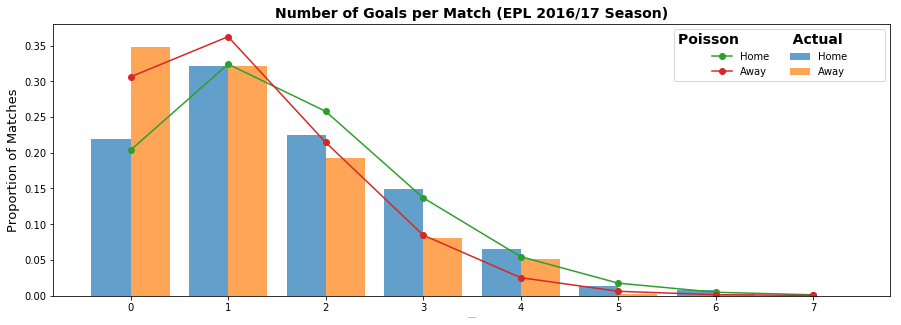

In [61]:
# construct Poisson  for each mean goals value, plot histogram of actual goals and add lines for the Poisson distributions
figsize(15, 5)
plt.hist(results[['HomeGoals', 'AwayGoals']].values, range(9), alpha=0.7, label=['Home', 'Away'],normed=True)
pois1 = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],linestyle='-', marker='o',label = 'Home')
pois2 = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],linestyle='-', marker='o',label="Away")
leg=plt.legend(loc='upper right', fontsize=10,ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=1)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')

plt.show()

Through this graph, we can say that although the specific probability between poisson and actual are different,but the trends of them are similar.

Note that we consider the number of goals scored by each team to be independent events (i.e. P(A n B) = P(A) P(B)). The difference of two Poisson distribution is actually called a Skellam distribution. So we can calculate the probability of a draw by inputting the mean goal values into this distribution.

In [64]:
# probability of draw between home and away team
skellam.pmf(0.0,  results.mean()[0],  results.mean()[1])

0.24809376810717076

In [65]:
# probability of home team winning by one goal
skellam.pmf(1,  results.mean()[0],  results.mean()[1])

0.22706765807563964

/home/chuanjie/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


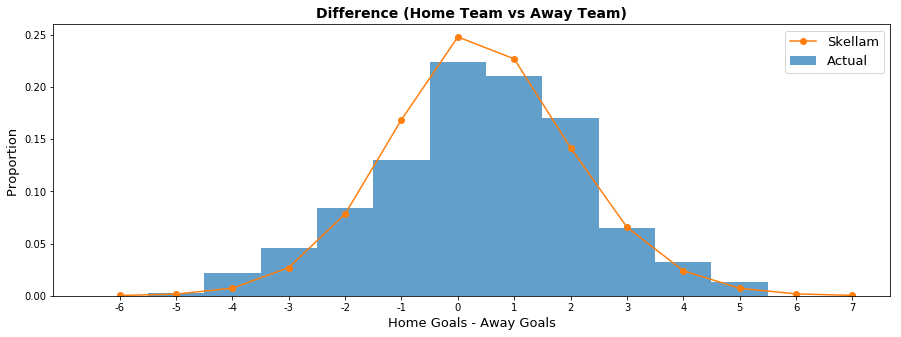

In [12]:
figsize(15, 5)
skellam_pred = [skellam.pmf(i,  results.mean()[0],  results.mean()[1]) for i in range(-6,8)]
plt.hist(results[['HomeGoals']].values -results[['AwayGoals']].values, range(-6,8), alpha=0.7, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,linestyle='-', marker='o',label="Skellam")
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion ",size=13)
plt.title("Difference (Home Team vs Away Team)",size=14,fontweight='bold')
plt.show()

 We just need to know the average number of goals scored by each team and feed this data into a Poisson model. 

## Building A Model

we could now calculate the probability of various events in this Chelsea Sunderland match. But rather than treat each match separately, we'll build a more general Poisson regression model 

In [14]:
# rebuild the data
data = pd.concat([results[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           results[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
data.head()

,team,opponent,goals,home
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1


In [15]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=data, 
                        family=sm.families.Poisson()).fit()

In [16]:
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Tue, 04 Jun 2019   Deviance:                       776.11
Time:                        16:25:09   Pearson chi2:                     659.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      0.241     -1.754      0.079      -0.894       0.050
opponent[T.Middlesbrough]  

We are more interested in the values presented in the coef column in the model summary table,which are analogous to the slopes in linear regression.A positive value implies more goals , while values closer to zero represent more neutral effects Towards the bottom of the table you might notice that home has a coef of 0.2969. This captures the fact that home teams generally score more goals than the away team.Man City has an estimate of 0.0117, while the corresponding value for Sunderland is -0.9619.
Finally, the opponent values penalize teams based on the quality of the opposition. This reflects the defensive strength of each team (Chelsea: -0.0993; Sunderland: 0.3707). In other words, you're less likely to score when you are against Man City.

In [17]:
poisson_model.predict(pd.DataFrame(data={'team': 'Man City', 'opponent': 'Sunderland',
                                       'home':1},index=[1]))

1    2.862819
dtype: float64

In [18]:
poisson_model.predict(pd.DataFrame(data={'team': 'Sunderland', 'opponent': 'Man City',
                                       'home':0},index=[1]))

1    0.502182
dtype: float64

In [19]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=3)

array([[0.03108485, 0.01272529, 0.00260469, 0.00035543],
       [0.0951713 , 0.03896054, 0.00797469, 0.00108821],
       [0.14569118, 0.059642  , 0.01220791, 0.00166586],
       [0.14868571, 0.06086788, 0.01245883, 0.0017001 ]])

This matrix simply shows the probability of Chelsea (rows of the matrix) and Sunderland (matrix columns) scoring a specific number of goals. For example, along the diagonal, both teams score the same the number of goals (e.g. P(0-0)=0.031). So, you can calculate the odds of draw by summing all the diagonal entries. Everything below the diagonal represents a Chelsea victory (e.g P(3-0)=0.149), And you can estimate P(Over 2.5 goals) by summing all entries except the four values in the upper left corner. 

In [23]:
chel_sum = simulate_match(poisson_model, "Man City", "Sunderland", max_goals=10)
# Man City win
np.sum(np.tril(chel_sum, -1))

0.8533353555385607

In [24]:
# draw
np.sum(np.diag(chel_sum))

0.10523328232600788

In [25]:
# sunderland win
np.sum(np.triu(chel_sum, 1))

0.041233819387901716

## Conclusion
We built a simple Poisson model to predict the results of English Premier League matches.
In conclusion, don't wager the money, but it's a good starting point for more sophisticated realistic models. 